In [126]:
import codecs
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
import re
import string
from string import digits

In [127]:
df = pd.read_csv('C:/Users/Богдан/Downloads/rus.txt', sep='\t',)
df.columns=['English', 'Russian', 'Others']
df = df[['English', 'Russian']]
df

English  \
0                                                     Go.   
1                                                     Go.   
2                                                     Hi.   
3                                                     Hi.   
4                                                     Hi.   
...                                                   ...   
363380  In today's world, we have to equip all our kid...   
363381  Death is something that we're often discourage...   
363382  At a moment when our economy is growing, our b...   
363383  Since there are usually multiple websites on a...   
363384  Doubtless there exists in this world precisely...   

                                                  Russian  
0                                                    Иди.  
1                                                  Идите.  
2                                           Здравствуйте.  
3                                                 Привет!  
4                                                    Хай.  
...                                                   ...  
363380  В современном мире перед нами стоит задача дат...  
363381  Смерть - это зачастую то, разговоры или даже м...  
363382  В тот момент, когда наша экономика растёт, наш...  
363383  Поскольку сайтов, посвящённых какой-либо теме,...  
363384  Несомненно, для каждого мужчины в этом мире гд...  

[363385 rows x 2 columns]

In [128]:
df_1 = df.iloc[:50000]

df_2 = df_1
df_1

English                   Russian
0                      Go.                      Иди.
1                      Go.                    Идите.
2                      Hi.             Здравствуйте.
3                      Hi.                   Привет!
4                      Hi.                      Хай.
...                    ...                       ...
49995  I think I know you.  Мне кажется, я Вас знаю.
49996  I think I know you.     По-моему, я Вас знаю.
49997  I think I know you.    По-моему, я тебя знаю.
49998  I think I know you.     По-моему, мы знакомы.
49999  I think I love you.      Думаю, я люблю тебя.

[50000 rows x 2 columns]

In [129]:
#def replace_and_nltk(df_2,column):
df_2['English'] = df_2['English'].str.replace(r'[^\w\d\s]', ' ')
df_2['Russian'] = df_2['Russian'].str.replace(r'[^\w\d\s]', ' ')
df_2['English'] = df_2['English'].str.replace(r'\s+', ' ')
df_2['Russian'] = df_2['Russian'].str.replace(r'\s+', ' ')
df_2['English'] = df_2['English'].str.replace(r'^\s+|\s*?$', ' ')
df_2['Russian'] = df_2['Russian'].str.replace(r'^\s+|\s*?$', ' ')
df_2['English'] = df_2['English'].replace(r'\d+(\.\d+)?', 'number')
df_2['Russian'] = df_2['Russian'].replace(r'\d+(\.\d+)?', 'number')
#df_2['English'] = df_2['English'].lower()
#df_2['Russian'] = df_2['Russian'].lower()
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words1 = set(stopwords.words("english"))
stop_words2 = set(stopwords.words("russian"))
df_2['English'] = df_2['English'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words1))
df_2['Russian'] = df_2['Russian'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words2))
ps = nltk.PorterStemmer()
df_2['English'] = df_2['English'].apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))
df_2['Russian'] = df_2['Russian'].apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))
df_2['Russian'] = df_2['Russian'].apply(lambda x : 'START_ '+ x + ' _END')
df_2

C:\Users\9234~1\AppData\Local\Temp/ipykernel_10604/617551336.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_2['English'] = df_2['English'].str.replace(r'[^\w\d\s]', ' ')
C:\Users\9234~1\AppData\Local\Temp/ipykernel_10604/617551336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['English'] = df_2['English'].str.replace(r'[^\w\d\s]', ' ')
C:\Users\9234~1\AppData\Local\Temp/ipykernel_10604/617551336.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_2['Russian'] = df_2['Russian'].str.replace(r'[^\w\d\s]', ' ')
C:\Users\9234~1\AppData\Local\Temp/ipykernel_10604/617551336.py:3: SettingWithCopyWarning: 
A value is trying to be set on

English                           Russian
0                  go                   START_ иди _END
1                  go                 START_ идите _END
2                  hi          START_ здравствуйте _END
3                  hi                START_ привет _END
4                  hi                   START_ хай _END
...               ...                               ...
49995  i think i know  START_ мне кажется вас знаю _END
49996  i think i know     START_ по моему вас знаю _END
49997  i think i know         START_ по моему знаю _END
49998  i think i know      START_ по моему знакомы _END
49999  i think i love           START_ думаю люблю _END

[50000 rows x 2 columns]

In [75]:
df_2.English=df_2.English.apply(lambda x: x.lower())
df_2.Russian=df_2.Russian.apply(lambda x: x.lower())
# Remove quotes from source and target text
df_2.English=df_2.English.apply(lambda x: re.sub("'", '', x))
df_2.Russian=df_2.Russian.apply(lambda x: re.sub("'", '', x))
# create a set of all special characters
special_characters= set(string.punctuation)
# Remove all the special characters
df_2.English = df_2.English.apply(lambda x: ''.join(char1 for char1 in x if char1 not in special_characters))
df_2.Russian = df_2.Russian.apply(lambda x: ''.join(char1 for char1 in x if char1 not in special_characters))
# Remove digits from source and target sentences
num_digits= str.maketrans('','', digits)
df_2.English=df_2.English.apply(lambda x: x.translate(num_digits))
df_2.Russian= df_2.Russian.apply(lambda x: x.translate(num_digits))
# Remove extra spaces
df_2.English=df_2.English.apply(lambda x: x.strip())
df_2.Russian=df_2.Russian.apply(lambda x: x.strip())
df_2.English=df_2.English.apply(lambda x: re.sub(" +", " ", x))
df_2.Russian=df_2.Russian.apply(lambda x: re.sub(" +", " ", x))
df_2.Russian = df_2.Russian.apply(lambda x : 'START_ '+ x + ' _END')

c:\users\богдан\appdata\local\programs\python\python39\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [130]:
English_length_list=[]
for l in df_2.English:
    English_length_list.append(len(l.split(' ')))
max_English_length= max(English_length_list)
#print(" Max length of the source sentence",max_source_length)
Russian_length_list=[]
for l in df_2.Russian:
    Russian_length_list.append(len(l.split(' ')))
max_Russian_length= max(Russian_length_list)

In [131]:
all_English_words=set()
for English in df_2.English:
    for word in English.split():
        if word not in all_English_words:
            all_English_words.add(word)
 
all_Russian_words=set()
for Russian in df_2.Russian:
    for word in Russian.split():
        if word not in all_Russian_words:
            all_Russian_words.add(word)
English_words= sorted(list(all_English_words))
Russian_words=sorted(list(all_Russian_words))
num_encoder_tokens=len(English_words)+1
num_decoder_tokens=len(Russian_words)+1

In [132]:
English_word2idx= dict([(word, i+1) for i,word in enumerate(English_words)])
Russian_word2idx=dict([(word, i+1) for i, word in enumerate(Russian_words)])
English_idx2word= dict([(i, word) for word, i in  English_word2idx.items()])
print(English_idx2word)
Russian_idx2word =dict([(i, word) for word, i in Russian_word2idx.items()])

{1: '0', 2: '00', 3: '000', 4: '1', 5: '10', 6: '100', 7: '105', 8: '11', 9: '12', 10: '13', 11: '1374', 12: '15', 13: '16', 14: '17', 15: '18', 16: '19', 17: '1960', 18: '2', 19: '20', 20: '2003', 21: '2009', 22: '2013', 23: '20th', 24: '223', 25: '24', 26: '25', 27: '3', 28: '30', 29: '300', 30: '303', 31: '3rd', 32: '4', 33: '42', 34: '45', 35: '5', 36: '50', 37: '6', 38: '65', 39: '7', 40: '70', 41: '8', 42: '839', 43: '9', 44: '911', 45: '99', 46: 'a', 47: 'aah', 48: 'aback', 49: 'abandon', 50: 'abat', 51: 'abl', 52: 'aboard', 53: 'about', 54: 'abroad', 55: 'absent', 56: 'absolut', 57: 'absorb', 58: 'absurd', 59: 'abus', 60: 'acceler', 61: 'accept', 62: 'accid', 63: 'account', 64: 'accur', 65: 'ace', 66: 'ach', 67: 'acn', 68: 'acquit', 69: 'acrobat', 70: 'across', 71: 'acryl', 72: 'act', 73: 'action', 74: 'activ', 75: 'actor', 76: 'actress', 77: 'ad', 78: 'adapt', 79: 'add', 80: 'addict', 81: 'address', 82: 'adequ', 83: 'adjourn', 84: 'adjust', 85: 'admir', 86: 'admiss', 87: 'admi

In [133]:
#df_2 = shuffle(df_2)

In [134]:
#df_2.English = df_2.English.apply(lambda x: ' '.join([str(elem) for elem in x]))
#df_2.Russian = df_2.Russian.apply(lambda x: ' '.join([str(elem) for elem in x]))
X, y = df_2.English, df_2.Russian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [135]:


def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_English_length),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_Russian_length),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_Russian_length, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = English_word2idx[word] 
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = Russian_word2idx[word]
                    if t>0:
                        decoder_target_data[i, t - 1, Russian_word2idx[word]] = 1.
                    
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [136]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 10
latent_dim=256

In [137]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [138]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, None, 256)    923136      ['input_19[0][0]']               
                                                                                                  
 embedding_15 (Embedding)       (None, None, 256)    3450368     ['input_20[0][0]']               
                                                                                           

In [139]:
h = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
              steps_per_epoch = train_samples//batch_size,
              epochs = epochs,
              validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
              validation_steps = val_samples//batch_size)

Epoch 1/10


C:\Users\9234~1\AppData\Local\Temp/ipykernel_10604/1851821240.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),


312/312 [==============================] - 72s 218ms/step - loss: 1.8889 - acc: 0.3917 - val_loss: 1.6590 - val_acc: 0.4492
Epoch 2/10
312/312 [==============================] - 78s 252ms/step - loss: 1.5495 - acc: 0.4665 - val_loss: 1.5310 - val_acc: 0.4775
Epoch 3/10
312/312 [==============================] - 78s 252ms/step - loss: 1.4169 - acc: 0.4899 - val_loss: 1.4599 - val_acc: 0.4968
Epoch 4/10
312/312 [==============================] - 81s 258ms/step - loss: 1.3136 - acc: 0.5075 - val_loss: 1.4017 - val_acc: 0.5103
Epoch 5/10
312/312 [==============================] - 80s 258ms/step - loss: 1.2223 - acc: 0.5239 - val_loss: 1.3488 - val_acc: 0.5226
Epoch 6/10
312/312 [==============================] - 80s 257ms/step - loss: 1.1425 - acc: 0.5410 - val_loss: 1.3000 - val_acc: 0.5318
Epoch 7/10
312/312 [==============================] - 80s 257ms/step - loss: 1.0701 - acc: 0.5576 - val_loss: 1.2574 - val_acc: 0.5417
Epoch 8/10
312/312 [==============================] - 81s 259ms/st

In [141]:
model.save_weights('my_model1.h5')

In [142]:
# Encode the input sequence to get the "Context vectors"
encoder_model = Model(encoder_inputs, encoder_states)
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_input)
decoder_states2 = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)
# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_state_input,
    [decoder_outputs2] + decoder_states2)

In [170]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = Russian_word2idx['START_']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = Russian_idx2word[sampled_token_index]
        decoded_sentence += ' '+ sampled_word
        if (sampled_word == '_END' or len(decoded_sentence) > 50):
           stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence

In [171]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [172]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Source sentence:', X_train[k:k+1].values[0])
print('Actual Target Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Target Translation:', decoded_sentence[:-4])

Input Source sentence: tom old man
Actual Target Translation:  том старый человек 
Predicted Target Translation:  том старый человек 


In [178]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
k=20
#k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence1 = decode_sequence(input_seq)
print('Input Source sentence:', X_test[k:k+1].values[0])
print('Actual Target Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Target Translation:', decoded_sentence1[:-4])

Input Source sentence: whi sad
Actual Target Translation:  почему грустишь 
Predicted Target Translation:  вы очень молоды 


In [ ]:
#Part 2

In [18]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch import nn, optim
from matplotlib import pyplot as plt
import seaborn as sns

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [30]:
path = 'D:/lab5 Data/pokemonn'
os.path.exists(path)

True

In [31]:
norm=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
batch_size = 64
image_size = 64
transf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*norm,inplace=True),
])

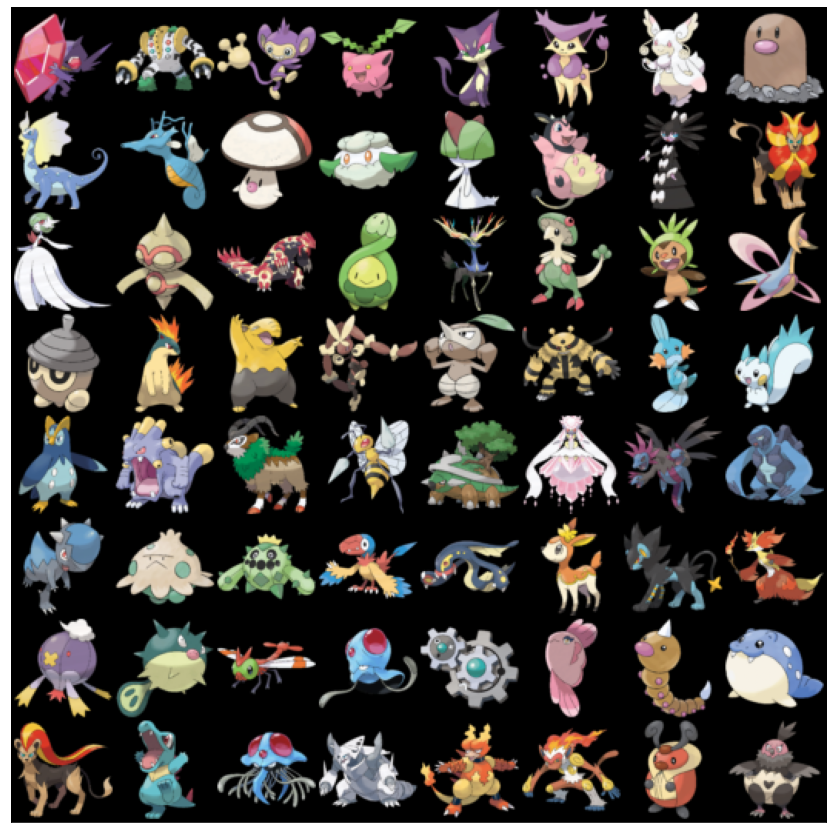

In [32]:
from torchvision import datasets

dataset = datasets.ImageFolder(root=path,transform=transf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        unnorm_images = unnorm(images, *norm)
        ax.imshow(make_grid(unnorm_images[:batch_size], nrow=8).permute(1, 2, 0).clamp(0,1))
        break
show_batch(dataloader)

In [33]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

modelG = Generator()
modelG.to(device)
modelG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [34]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
modelD = Discriminator()
modelD.to(device)
modelD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [39]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(modelD.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(modelG.parameters(), lr=0.0001, betas=(0.5, 0.999))

import torchvision.utils as vutils

img_list = []
G_losses, D_losses = [], []
total = 0

for epoch in range(50):
    g_loss = 0.0
    d_loss = 0.0
    D_x = 0.0
    D_G_z1 = 0.0
    D_G_z2 = 0.0
    
    for i, data in enumerate(dataloader, 0):
        
        modelD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = modelD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x += output.mean().item()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = modelG(noise)
        label.fill_(fake_label)
        output = modelD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 += output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        modelG.zero_grad()
        label.fill_(real_label)
        output = modelD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 += output.mean().item()
        optimizerG.step()
        
        g_loss += errG.item()
        d_loss += errD.item()
        total += b_size
        
    avg_g_loss = g_loss / total
    G_losses.append(avg_g_loss)
    avg_d_loss = d_loss / total
    D_losses.append(avg_d_loss)
    
    avg_D_x = D_x / len(dataloader)
    avg_D_G_z1 = D_G_z1 / len(dataloader)
    avg_D_G_z2 = D_G_z2 / len(dataloader)
    
    print('Epoch: {} \tDiscriminator Loss: {:.6f} \tGenerator Loss: {:.6f} \tD(x): {:.6f} \tD(G(z)): {:.6f} / {:.6f}'.format(
        epoch + 1,
        avg_d_loss,
        avg_g_loss,
        avg_D_x,
        avg_D_G_z1,
        avg_D_G_z2
    ))
    
    with torch.no_grad():
        fake = modelG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(unnorm(fake, *norm), padding=2, normalize=True))

Epoch: 1 	Discriminator Loss: 0.006250 	Generator Loss: 0.070462 	D(x): 0.871675 	D(G(z)): 0.142704 / 0.048634
Epoch: 2 	Discriminator Loss: 0.004684 	Generator Loss: 0.040469 	D(x): 0.842112 	D(G(z)): 0.176581 / 0.060271
Epoch: 3 	Discriminator Loss: 0.001517 	Generator Loss: 0.023665 	D(x): 0.875862 	D(G(z)): 0.115131 / 0.024761
Epoch: 4 	Discriminator Loss: 0.002564 	Generator Loss: 0.022124 	D(x): 0.816979 	D(G(z)): 0.180941 / 0.067888
Epoch: 5 	Discriminator Loss: 0.000879 	Generator Loss: 0.013841 	D(x): 0.882209 	D(G(z)): 0.113241 / 0.029214
Epoch: 6 	Discriminator Loss: 0.000527 	Generator Loss: 0.013190 	D(x): 0.919188 	D(G(z)): 0.094128 / 0.011184
Epoch: 7 	Discriminator Loss: 0.000810 	Generator Loss: 0.012779 	D(x): 0.878087 	D(G(z)): 0.121227 / 0.032708
Epoch: 8 	Discriminator Loss: 0.000663 	Generator Loss: 0.010053 	D(x): 0.881438 	D(G(z)): 0.134880 / 0.037275
Epoch: 9 	Discriminator Loss: 0.000554 	Generator Loss: 0.008863 	D(x): 0.884714 	D(G(z)): 0.105106 / 0.024768
E

In [40]:
torch.save(modelG.state_dict(), 'G.pth')
torch.save(modelD.state_dict(), 'D.pth')

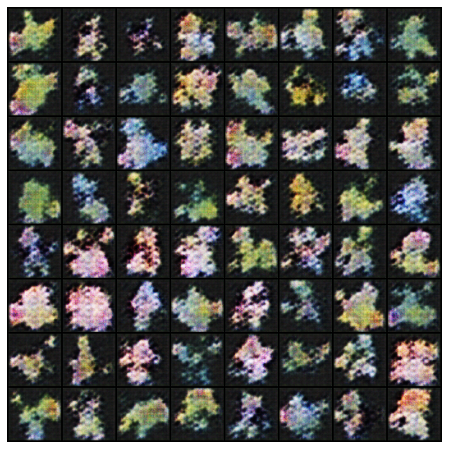

In [41]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[::15]]
ani = animation.ArtistAnimation(fig, ims, interval=250, repeat_delay=250, blit=True)

HTML(ani.to_jshtml())